# Our own model

In [23]:
%load_ext autoreload
%autoreload 2

### We decided to go with catboost as our black-box model as it is better fitted to categorical data such as this one, in which we have to predict whether an individual will default (1) or not (0).

In [7]:
import pandas as pd
from pathlib import Path

In [8]:
path = Path("../Data/dataproject2024.xlsx")
df = pd.read_excel(path)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7430 entries, 0 to 7429
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    7430 non-null   int64  
 1   Job tenure            7430 non-null   int64  
 2   Age                   7430 non-null   int64  
 3   Car price             7430 non-null   int64  
 4   Funding amount        7430 non-null   int64  
 5   Down payment          7430 non-null   int64  
 6   Loan duration         7430 non-null   int64  
 7   Monthly payment       7430 non-null   float64
 8   Credit event          7430 non-null   int64  
 9   Married               7430 non-null   int64  
 10  Homeowner             7430 non-null   int64  
 11  Default (y)           7430 non-null   int64  
 12  Pred_default (y_hat)  7430 non-null   int64  
 13  PD                    7430 non-null   float64
 14  Group                 7430 non-null   int64  
dtypes: float64(2), int64(

In [9]:
df.set_index("ID", inplace=True)
df

,Job tenure,Age,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner,Default (y),Pred_default (y_hat),PD,Group
ID,,,,,,,,,,,,,,
1,34,55,4875,3087,0,36,0.047895,0,1,1,0,0,0.024480,1
2,5,29,13000,13000,0,60,0.091667,0,0,0,1,0,0.331661,0
3,14,38,17190,14190,0,60,0.088235,0,0,0,0,0,0.187505,0
4,16,37,22773,23568,0,48,0.110084,0,1,1,0,0,0.035441,1
5,1,61,7700,8526,0,48,0.123404,0,1,0,1,0,0.340883,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7426,9,38,4502,4856,0,48,0.083846,1,0,0,1,0,0.217708,0
7427,1,33,22900,17900,0,60,0.098000,0,0,0,0,0,0.063937,0
7428,3,27,25858,25972,0,24,0.181667,0,0,0,0,1,0.630863,0


In [10]:
from sklearn.model_selection import train_test_split

X = df.drop(["Default (y)", "Pred_default (y_hat)", "PD", "Group"], axis=1)
y = df["Default (y)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(iterations=20, depth=10, learning_rate=0.1, loss_function="Logloss", verbose=False)
cat_model.fit(X_train, y_train)

In [12]:
y_pred_class = cat_model.predict(X_test)
y_pred_prob = cat_model.predict_proba(X_test)[:,0]

In [13]:
df_pred = pd.DataFrame([y_pred_class, y_pred_prob]).transpose()
df_pred = df_pred.rename(columns={0: "y_hat", 1:"prob_default"})
df_pred

,y_hat,prob_default
0,0.0,0.636127
1,0.0,0.654572
2,0.0,0.680751
3,0.0,0.565499
4,0.0,0.749870
...,...,...
2224,0.0,0.843255
2225,0.0,0.788954
2226,0.0,0.670906
2227,0.0,0.795939


In [14]:
from sklearn.metrics import accuracy_score

acc_cat = accuracy_score(df_pred["y_hat"], y_test)
acc_init_model = accuracy_score(df["Default (y)"], df["Pred_default (y_hat)"])

print(f'The accuracy with a CatboostClassifier model is {acc_cat: .3f}, whereas the accuracy of the initial model was {acc_init_model: .3f}.')

The accuracy with a CatboostClassifier model is  0.813, whereas the accuracy of the initial model was  0.847.


In [15]:
cat_model.save_model("cat_boost_model")

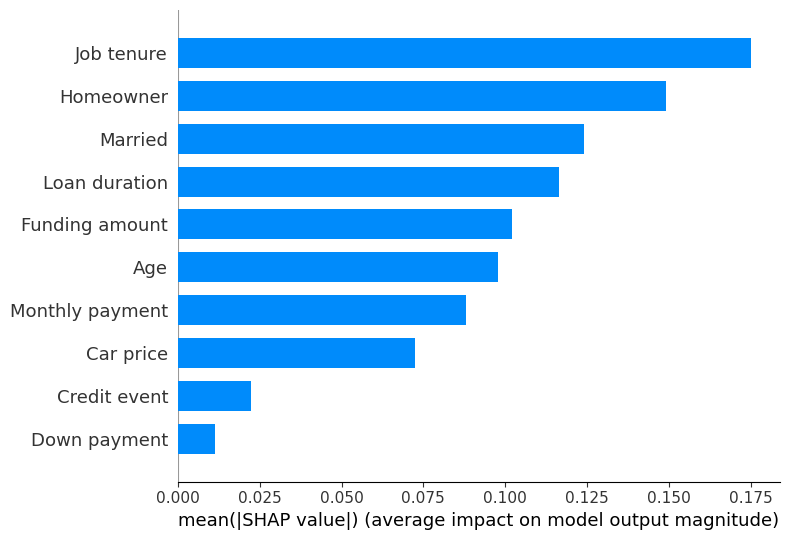

In [28]:
import sys
sys.path.append("..")

from src.shap import draw_shap_summary
draw_shap_summary(model=cat_model, data=X_train, model_name="cat_model")

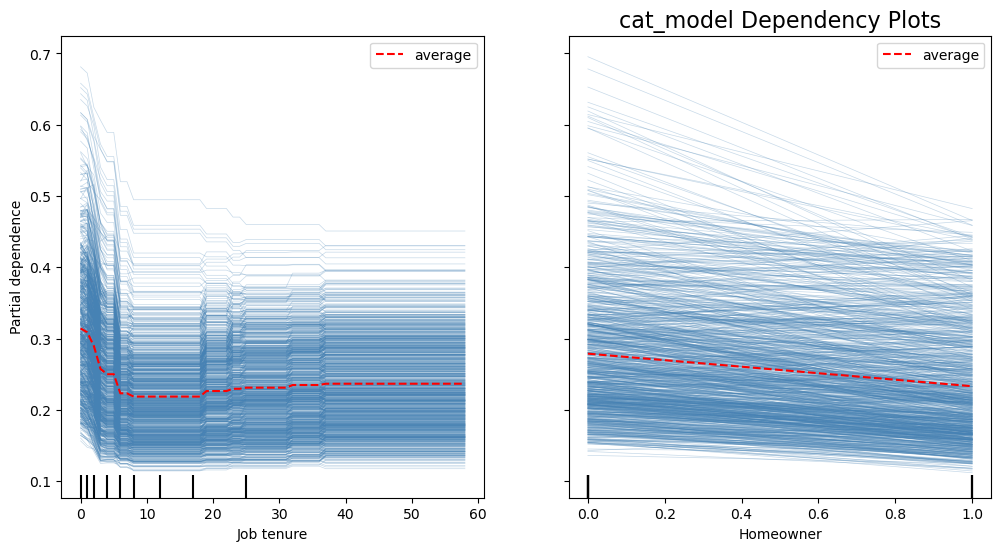

In [29]:
from src.pdp_ice import draw_pdp_ice_graphs
draw_pdp_ice_graphs(model=cat_model, data=X_train, model_name="cat_model", variables=["Job tenure", "Homeowner"])